# Comparing the performance of Neural networks and Gradient boosted trees  , and a stacked ensemble of both in MHC class I binding prediction


---
### Background

The prediction of MHC peptide binding is an important method in immunology. Data driven methods give best performance for this task because of complexity of the MHC molecules and the binding process. The most successful machine learning models were Neural networks in this area.  I have seen articles describing SVM models, but nobody has tried gradient boosted trees (as far as I know).


In the last years the vast majority of Data science competitions were won with a framework called Gradient Boosted Trees. These models very frequently outperform neural networks in gereal machine learning tasks. 

These facts gave me the idea to compare the perfomance of  Neural networks  and Gradient boosted trees and in MHC class I peptide binding prediction.

Also Neural networks and Gradient boosted trees are very different models, therefore ensembling them can give a really big boost to performance. So I tried to ensemble these models.


----
### Data

#### Source
I have downloaded MHC class I peptide binding data which has been used in this benchmark article ( http://www.ncbi.nlm.nih.gov/pubmed/25017736)  from the IEDB website.


#### Encoding 

Input data is very simply coded as the folowing:
- zero padded sequences to the longest peptide length
- amino acids are encoded in a one hot scheme
- species are encoded in a one hot scheme
- HLA types are encoded in a one-hot scheme
- HLA loci are encoded in a one-hot scheme
- HLA serotypes are encoded in a one-hot scheme
- peptide lengths are included

#### Target 

I predicted binary binding labels based on the IC > 500nM threshold.


---

### Models

#### Neural network

I used a neural network architecture similar to the one used in NetMHCpan.
- 1 hidden layer
- 60 units in the hidden layer

I used the Keras software library. http://keras.io


#### Gradient boosted trees
Some resources about the model:
- http://xgboost.readthedocs.org/en/latest/model.html
- http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf
    
I used the XGBoost software library. http://xgboost.readthedocs.org/en/latest/


#### Ensembling



I used a stacking approach for ensembling. I used original features, and probabilities predicted by base models as input for the meta estimator. The same folds are used in both step to prevent label leakage.

Original article about stacking.
- http://www.sciencedirect.com/science/article/pii/S0893608005800231




---

### Methods


I made 5-fold cross validation evaluations, with AUC for all the measurements. All models can use early stopping on validation data so 3:1:1 scheme was used in each fold: 3 subsets for training 1 for validation and 1 for only prediction.



--- 

### Conclusions


Gradient boosted trees significantly outperform neural networks in this task. The ensemble of neural networks and gradient boosted trees gives further improvement over the base models. NetMHCPan performance is very similar to the ensemble model on this dataset.


Method | 5 fold CV
--- | --- 
NN | 0.9172
Gradient boosted trees | 0.9355
Ensemble of Gradient boosted trees + NN | 0.9377
NetMHCpan | 0.9376


The ensemble has better results than NetMHCpan on peptide length 8,10,11,12, but please note that these NetMHCpan results from the article were obtained with the L-mer approximation, not the newest representation on peptids of different length.

---


### Future Work

#### Training on similar data than NetMHCpan

The ensemble model performs comparably to NetMHCpan which is considered to be the state of the art model in MHC class I prediction. 

But NetMHCpan uses sophsticated encoding of the MHC molecules with pseudo sequences, a sophisticated way for predicting different length peptides and it is an ensemble of many models trained on different representations. 

**I think that Gradient Boosted trees trained on the same data used for NetMHCpan training, and using ensembling trees and neural networks could significanlty improve the current state of the art.**



----
#### Notes

- To run this notebook you need to 
    - download the dataset
    - export the MHC_DATA variable
    - and have keras,theno,xgboost,sklearn,pandas,numpy installed.
    
    
- This notebook can be run as it is. Just click run all. 
    - It takes some time but on a stronger computer it should be less than 30 minutes.


----


This notebook was created by Dezso Ribli

### Load modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#go to working dir
import os
os.chdir(os.environ['MHC_DIR'])

Using Theano backend.
/home/ribli/tools/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Data Loader functions

In [2]:
def load_data():
    """Load train/blind test data as in the benchmark."""
    
    #load the cross validation data
    dataf='benchmark_mhci_reliability/binding/bd2009.1/bdata.2009.mhci.public.1.txt'
    data=pd.read_csv(dataf,sep='\t')
     
    #encode hla,species,amino acids,in a one hot scheme
    X_hla=one_hot_encode(data.mhc.values,data.mhc.values)
    X_hla_loci=encode_hla_loci(data.mhc.values,data.mhc.values)
    X_hla_sero=encode_hla_sero(data.mhc.values,data.mhc.values)
    X_species=one_hot_encode(data.species.values,data.species.values)
    X_seq=encode_seq(data.sequence.values,data.sequence.values)
    
    #stack columns
    X=np.column_stack([X_species,
                       X_hla,
                       X_hla_loci,
                       X_hla_sero,
                       X_seq,
                       data.peptide_length.values])
    
    #make binding class labels
    y=np.ones(len(data.meas))
    y[data.meas.values>=500]=0

    #permute arrays as they are ordered!!!
    rng=np.random.RandomState(42)
    perm=rng.permutation(len(X))
    X,y,data=X[perm],y[perm],data.iloc[perm,:]
    
    return X,y,data


def one_hot_encode(x_all,x_in):
    """One hot encode categorical variable."""
    lb = LabelBinarizer()
    lb.fit(x_all)
    x_out=lb.transform( x_in )
    return x_out


def encode_seq(x_all,x_in):
    """Encode string amino acid sequences to numbers."""
    #zero pad peptids to equal length
    maxlen=np.max(map(len,x_all))
    x_temp_all=np.array([list(x.zfill(maxlen)) for x in x_all])
    x_temp_in=np.array([list(x.zfill(maxlen)) for x in x_in])
    
    lb = LabelBinarizer()
    lb.fit(x_temp_all.flatten())
    x_out=np.column_stack([lb.transform(x_temp_in[:,i]) for i in range(maxlen)])

    return x_out


def encode_hla_loci(x_all,x_in):
    """Encode string HLA loci to numbers."""
    #get 1st subtype
    new_x_all=[x.split('-')[1][0] for x in x_all]
    new_x_in=[x.split('-')[1][0] for x in x_in]
    
    return one_hot_encode(new_x_all,new_x_in)


def get_serotype(hla_type):
    """Parse serotype from hla type."""
    if len(hla_type.split('-'))<3:
        return '0'
    else:
        return hla_type.split('-')[2][:2]

    
def encode_hla_sero(x_all,x_in):
    """Encode string HLA serotype to numbers."""
    #get 1st subtype
    new_x_all=[get_serotype(x) for x in x_all]
    new_x_in=[get_serotype(x) for x in x_in]
    
    return one_hot_encode(new_x_all,new_x_in)

----


### Cross validation scheme for both models


In [3]:
def cv(fitter,model_spec,X,y,n_folds=5):
    """Evaluate XGB model with cross validation."""
    #result
    y_pred=np.zeros(len(y))
    #loop folds
    for train_index,test_index in KFold(len(X),n_folds=n_folds):
        #train and predict
        y_pred[test_index]=fitter(model_spec,X[train_index],y[train_index],X[test_index])
    return y_pred


def keras_fit_predict(get_model,X_train,y_train,X_test,
                      validation_split=0.1,patience=1,nb_epoch=100,**kwargs):
    """Fit model on train test set with early stopping."""
    #get model
    model=get_model(X_train.shape[1])
    
    #callbacks
    best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=2)
    early_stop=EarlyStopping(patience=patience,verbose=2)
    
    #train it
    model.fit(X_train,y_train,nb_epoch = nb_epoch,validation_split=validation_split,
              callbacks=[best_model,early_stop],verbose=2,**kwargs)
    
    #load best model and predict
    model.load_weights('best_model')
    y_pred_test=model.predict(X_test).ravel()
    
    return y_pred_test

def xgb_fit_predict(params,X_train,y_train,X_test,num_boost_round=5000,verbose_eval=500,
                    early_stopping_rounds=200,validation_size=0.1):
    """Fit model on train test set with early stopping."""
    #split validation data for early stopping
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_size)
    
    #convert to data format for xgb
    dtrain = xgb.DMatrix( X_train, label=y_train)
    dvalid = xgb.DMatrix( X_valid, label=y_valid)
    dtest = xgb.DMatrix( X_test )
    
    #define printed evaluations
    evallist  = [(dtrain,'train'),(dvalid,'eval')]

    #lets train
    bst = xgb.train(params,dtrain,evals=evallist,
                    num_boost_round=num_boost_round,
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=verbose_eval)
    
    #make predictions
    y_pred_test=bst.predict(dtest)
    
    return y_pred_test

### Load data

In [4]:
X,y,data=load_data()

### Train NN in a CV scheme

In [5]:
#create a very simple NN model
def get_model(input_dim,n_dense=60):
    """Creates Keras model."""
    model = Sequential()
    model.add(Dense(n_dense, input_dim=input_dim,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

nn_cv_pred=cv(keras_fit_predict,get_model,X,y)

Train on 99110 samples, validate on 11013 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.40351, saving model to best_model
4s - loss: 0.4688 - val_loss: 0.4035
Epoch 2/100
Epoch 00001: val_loss improved from 0.40351 to 0.34621, saving model to best_model
4s - loss: 0.3723 - val_loss: 0.3462
Epoch 3/100
Epoch 00002: val_loss improved from 0.34621 to 0.33477, saving model to best_model
4s - loss: 0.3312 - val_loss: 0.3348
Epoch 4/100
Epoch 00003: val_loss improved from 0.33477 to 0.32292, saving model to best_model
4s - loss: 0.3070 - val_loss: 0.3229
Epoch 5/100
Epoch 00004: val_loss improved from 0.32292 to 0.31832, saving model to best_model
4s - loss: 0.2908 - val_loss: 0.3183
Epoch 6/100
Epoch 00005: val_loss did not improve
4s - loss: 0.2789 - val_loss: 0.3210
Epoch 7/100
Epoch 00006: val_loss improved from 0.31832 to 0.31287, saving model to best_model
4s - loss: 0.2699 - val_loss: 0.3129
Epoch 8/100
Epoch 00007: val_loss improved from 0.31287 to 0.30990, saving 

### Train gradient boosted trees in a CV scheme

In [6]:
#model params
params = {'max_depth':10,
         'eta':0.1,
         'min_child_weight':1,
         'colsample_bytree':0.66,
         'subsample':0.86,
         'silent':1,
         'objective': "binary:logistic",
         'eval_metric': 'auc',
         'nthread':4}

xgb_cv_pred=cv(xgb_fit_predict,params,X,y)

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.716450	eval-auc:0.702855
[500]	train-auc:0.980630	eval-auc:0.929944
[1000]	train-auc:0.994033	eval-auc:0.935559
[1500]	train-auc:0.997843	eval-auc:0.936527
Stopping. Best iteration:
[1351]	train-auc:0.997095	eval-auc:0.936653

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.654358	eval-auc:0.651563
[500]	train-auc:0.980717	eval-auc:0.923031
[1000]	train-auc:0.994172	eval-auc:0.929486
Stopping. Best iteration:
[1172]	train-auc:0.995935	eval-auc:0.930153

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.739321	eval-auc:0.744585
[500]	train-auc:0.980609	eval-auc:0.928742
[1000]	train-auc:0.993977	eval-auc:0.935229
[1500]	train-auc:0.997863	eval-auc:0.936389
Stopping. Best iteration:
[1589]	train-auc:0.998216	eval-auc:0.936535

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.731353	eval-auc:0.718416
[500]	train-auc:0.980376	eval-auc:

### Create a stacked ensemble of my NN and boosted tree models

In [7]:
#create stacked input
X_stacked=np.column_stack([X,xgb_cv_pred,nn_cv_pred])

#new params
params = {'max_depth':2,
         'eta':0.1,
         'min_child_weight':1,
         'colsample_bytree':1,
         'subsample':0.86,
         'silent':1,
         'objective': "binary:logistic",
         'eval_metric': 'auc',
         'nthread':4}

stacked_cv_pred=cv(xgb_fit_predict,params,X_stacked,y)

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.911032	eval-auc:0.906512
Stopping. Best iteration:
[102]	train-auc:0.939182	eval-auc:0.934216

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.910572	eval-auc:0.906717
Stopping. Best iteration:
[75]	train-auc:0.938726	eval-auc:0.933959

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.911282	eval-auc:0.910841
Stopping. Best iteration:
[85]	train-auc:0.938433	eval-auc:0.939928

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.912011	eval-auc:0.911024
Stopping. Best iteration:
[100]	train-auc:0.939393	eval-auc:0.939267

Will train until eval error hasn't decreased in 200 rounds.
[0]	train-auc:0.909624	eval-auc:0.907829
Stopping. Best iteration:
[144]	train-auc:0.939453	eval-auc:0.937643



### Load NetMHCpan predictions

In [8]:
def all_from_fname(fname):
    """Get allele from the filename"""
    # a bit convoluted naming
    return '_'.join(os.path.basename(fname).split('rnd.')[-1].split('.')[0].split('-')[:-1])

def load_allele_table(fname,allele):
    """Load a result table and annotate with allele"""
    #note they are .xls but csv files...
    tmp_table=pd.read_csv(fname,sep='\t')
    tmp_table['mhc']=allele.replace('_','-')
    tmp_table['peptide_length']=[len(x) for x in tmp_table.sequence]
    tmp_table['label']=(tmp_table.meas <= np.log10(500)).astype('int')
    return tmp_table

def load_all_tables(path):
    """Load all tables in directory and concat them into one big table"""
    return pd.concat([load_allele_table(f,all_from_fname(f)) for f in glob.glob(path)])

In [9]:
X,y,data=load_data()

In [10]:
#load cv tables
netmhc_cv_res=load_all_tables('benchmark_mhci_reliability/predictions/cv_rnd/netmhcpan/*')

### Evaluate all models

In [11]:
data['nn_pred']=nn_cv_pred
data['xgb_pred']=xgb_cv_pred
data['stacked_pred']=stacked_cv_pred
data['label']=y

#the netmhc predictions is only a subset of all data (3k missing)
# so only use the subset here
data=data.merge(netmhc_cv_res[['sequence','mhc']],on=['sequence','mhc'])

print "NN AUC:",roc_auc_score(data.label,data.nn_pred)
print "XGB AUC:",roc_auc_score(data.label,data.xgb_pred)
print "Ensemble AUC:",roc_auc_score(data.label,data.stacked_pred)
print
print "NetMHCpan AUC:", roc_auc_score(netmhc_cv_res.label,-netmhc_cv_res.pred)

NN AUC: 0.917271252174
XGB AUC: 0.93548495676
Ensemble AUC: 0.937725587032

NetMHCpan AUC: 0.937599369962


----

### Aggregate results by alleles

In [12]:
"""
A bit convoluted way to aggregate in pandas dataframes on multiple columns with different column names,
but now it will be okay. I will look into this later maybe.
"""

def agg_auc_nn(group):
    return agg_auc(group,'nn_pred')

def agg_auc_xgb(group):
    return agg_auc(group,'xgb_pred')

def agg_auc_stacked(group):
    return agg_auc(group,'stacked_pred')

def agg_auc_netmhc(group):
    y = group['label'].values
    pred = -group['pred'].values
    
    if len(np.unique(y))==1:
        return 1
    else:
        return roc_auc_score(y,pred)

def agg_auc(group,col):
    y = group['label'].values
    pred = group[col].values
    
    if len(np.unique(y))==1:
        return 1
    else:
        return roc_auc_score(y,pred)

In [13]:
## aggregate
grouped=data.groupby('mhc',as_index=False)

all_auc_df=grouped.agg(agg_auc_nn)[['mhc']]
all_auc_df['counts']=grouped['mhc'].size().values
all_auc_df['nn_auc']=grouped.agg(agg_auc_nn)[['cv']]
all_auc_df['xgb_auc']=grouped.agg(agg_auc_xgb)[['cv']]
all_auc_df['stacked_auc']=grouped.agg(agg_auc_stacked)[['cv']]

netmhc_cv_res['netmhc_auc']=0
netmhc_auc=netmhc_cv_res.groupby('mhc',as_index=False).agg(agg_auc_netmhc)[['mhc','netmhc_auc']]

#merge results to one dataframe
all_auc=netmhc_auc.merge(all_auc_df,on='mhc')

/home/ribli/tools/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


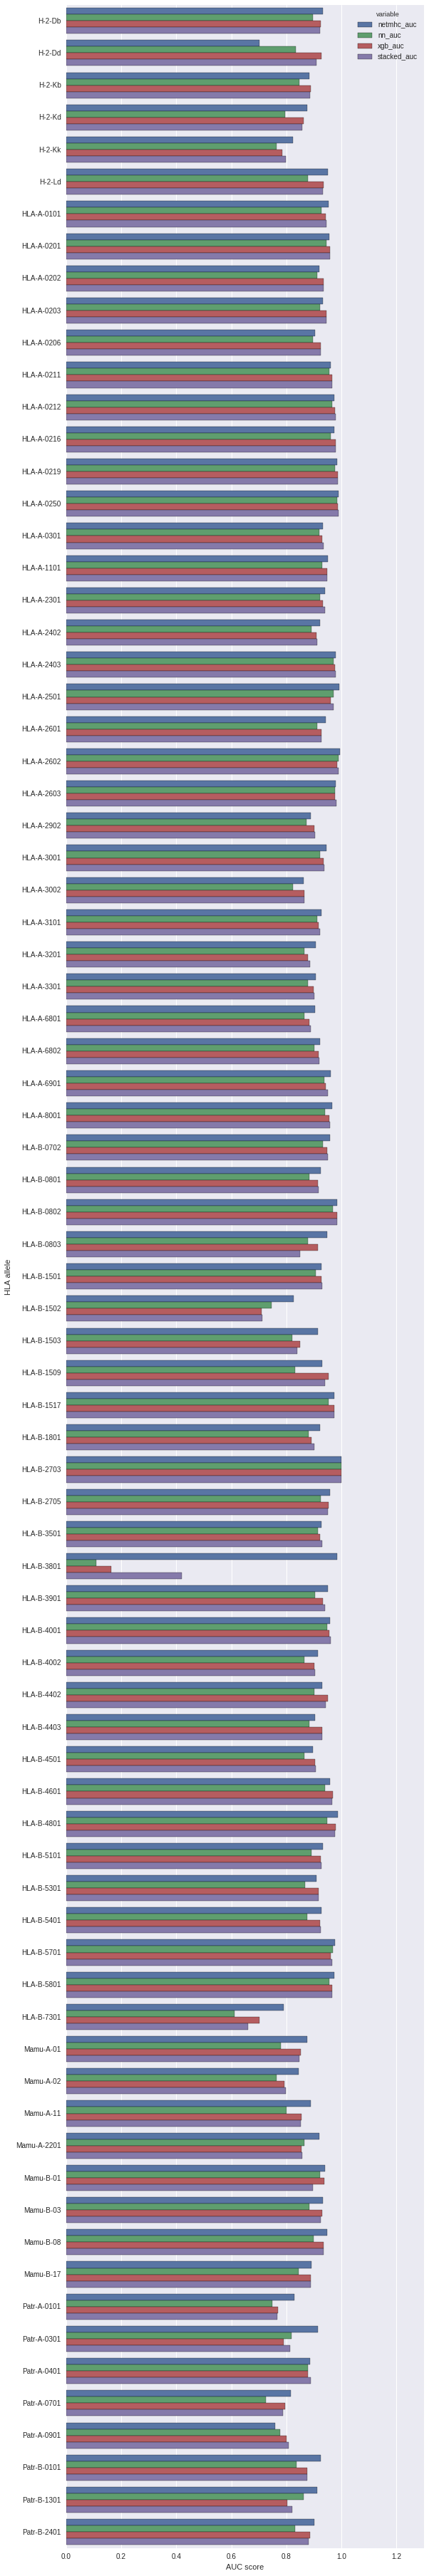

In [14]:
fig=plt.figure(figsize=(9,64))
tmp=pd.melt(all_auc, id_vars=['mhc','counts'])
sns.barplot(data=tmp,x='value',y='mhc',hue='variable')
plt.xlim(xmax=1.3)
plt.ylabel('HLA allele')
plt.xlabel('AUC score')

In [15]:
# there is one allele when my models have completely failed, but mhcpan is very good
all_auc[all_auc.mhc=='HLA-B-3801']

,mhc,netmhc_auc,counts,nn_auc,xgb_auc,stacked_auc
48,HLA-B-3801,0.984962,136,0.110276,0.162907,0.418546


----


### Aggregate results by peptide length

In [16]:
grouped=data.groupby('peptide_length',as_index=False)

len_auc_df=grouped.agg(agg_auc_nn)[['peptide_length']]
len_auc_df['counts']=grouped['peptide_length'].size().values
len_auc_df['nn_auc']=grouped.agg(agg_auc_nn)[['cv']]
len_auc_df['xgb_auc']=grouped.agg(agg_auc_xgb)[['cv']]
len_auc_df['stacked_auc']=grouped.agg(agg_auc_stacked)[['cv']]


netmhc_auc=netmhc_cv_res.groupby('peptide_length',as_index=False).agg(agg_auc_netmhc)[['peptide_length','netmhc_auc']]

#merge results to one dataframe
len_auc=netmhc_auc.merge(len_auc_df,on='peptide_length')

In [17]:
len_auc

,peptide_length,netmhc_auc,counts,nn_auc,xgb_auc,stacked_auc
0,8,0.891307,4943,0.873410,0.911115,0.907464
1,9,0.951734,99700,0.932997,0.947366,0.949261
2,10,0.891497,26954,0.864858,0.896965,0.898019
3,11,0.873929,2950,0.843987,0.877112,0.874304
4,12,0.709414,90,0.656783,0.821349,0.802817


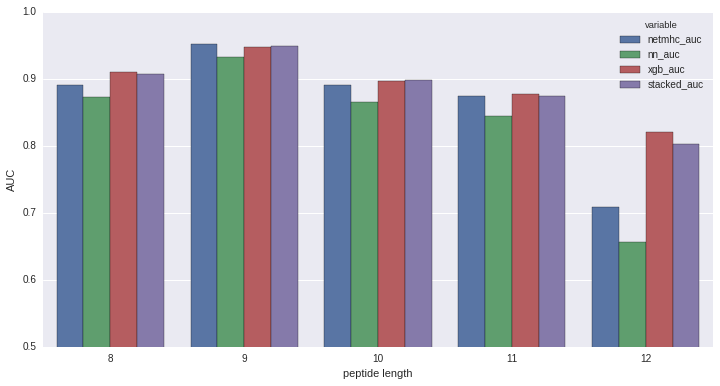

In [18]:
fig=plt.figure(figsize=(12,6))
temp=pd.melt(len_auc,id_vars=['peptide_length','counts'])
sns.barplot(data=temp,x='peptide_length',y='value',hue='variable')
plt.ylim(0.5,1)
plt.ylabel('AUC')
plt.xlabel('peptide length')